In [1]:
# ! pip install evaluate
# ! pip install seaborn
# ! pip install datasets
# ! pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, DataCollatorWithPadding, Trainer, \
                         AutoModelForSequenceClassification, TrainingArguments
from datasets import load_dataset
import evaluate

%matplotlib inline
sns.set()

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Анализ данных ##

Загрузим датасет и посмотрим его характеристики

In [4]:
dataset = load_dataset("AmazonScience/massive", "en-US")
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2974
    })
})

In [5]:
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

df_train.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,slot_method,judgments
0,1,en-US,train,16,48,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
1,2,en-US,train,16,48,set an alarm for two hours from now,set an alarm for [time : two hours from now],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
2,4,en-US,train,10,46,olly quiet,olly quiet,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
3,5,en-US,train,10,46,stop,stop,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
4,6,en-US,train,10,46,olly pause for ten seconds,olly pause for [time : ten seconds],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."


In [6]:
number_of_classes = len(df_train['intent'].value_counts())
number_of_classes

60

Text(0.5, 1.0, 'Распределение по классам, train')

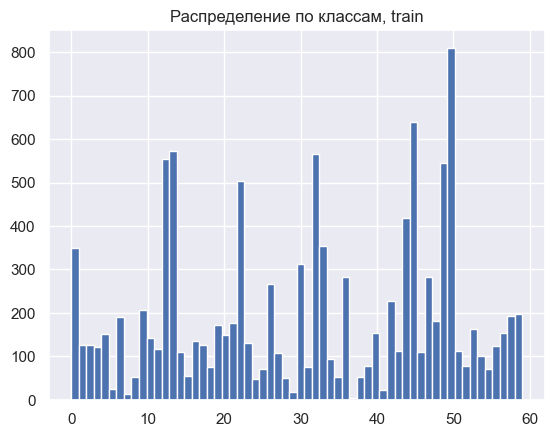

In [7]:
plt.hist(df_train['intent'], bins=number_of_classes)
plt.title('Распределение по классам, train')

**Вывод:** есть дисбаланс классов, также видно что класса ~37 вообще нет в train выборке. 
Стоит попробовать метод balanced weights в лосс-функции для задачи классификации с несбалансированными классами. 

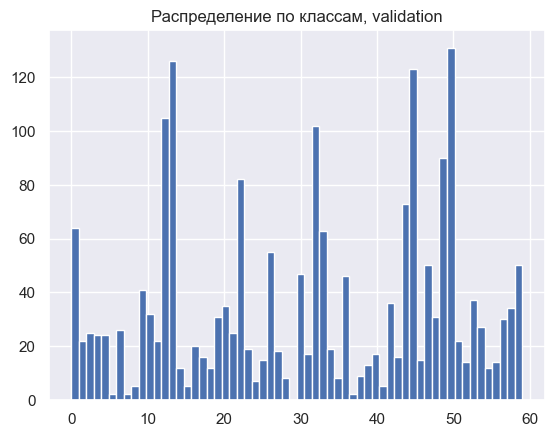

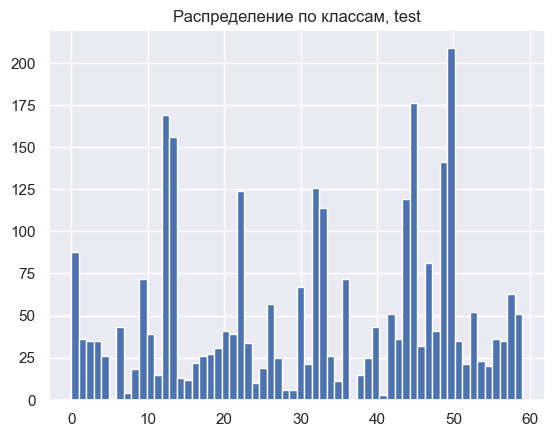

In [8]:
plt.hist(df_val['intent'], bins=number_of_classes)
plt.title('Распределение по классам, validation')
plt.show()

plt.hist(df_test['intent'], bins=number_of_classes)
plt.title('Распределение по классам, test')
plt.show()

In [9]:
# посмотрим какие вообще бывают запросы

df_train.drop_duplicates(subset=['intent'])

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,slot_method,judgments
0,1,en-US,train,16,48,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
2,4,en-US,train,10,46,olly quiet,olly quiet,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
6,9,en-US,train,8,1,make the lighting bit more warm here,make the lighting bit more [color_type : warm]...,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
8,12,en-US,train,8,40,time to sleep,time to sleep,0,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
11,16,en-US,train,8,31,olly dim the lights in the hall,olly dim the lights in the [house_place : hall],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
17,25,en-US,train,8,34,olly clean the flat,olly clean the [house_place : flat],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
21,33,en-US,train,2,32,check when the show starts,check when the show starts,71,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
22,34,en-US,train,3,45,i want to listen arijit singh song once again,i want to listen [artist_name : arijit singh] ...,58,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
24,36,en-US,train,9,12,check my car is ready,check my car is ready,71,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
31,45,en-US,train,9,5,what's up,what's up,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."


**Замечание:** распределение по классам в train, val, test совпадает. Может быть эта закономерность характеризует запросы в целом (например будильники ставят чаще чем спрашивают "what's up")?..

## Обучение модели ##

Целевая переменная - стобец *"intent"*, признак - текстовый запрос (столбец *"utt"*).
Метод - дообучаем AutoModelForSequenceClassification на основе distilbert-base-uncased

In [10]:
dataset = dataset.remove_columns(['id', 'locale', 'partition', 'scenario', 'annot_utt', 'worker_id', 'slot_method', 'judgments'])
dataset = dataset.rename_column('utt', 'texts')
dataset = dataset.rename_column('intent', 'labels')
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'texts'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['labels', 'texts'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['labels', 'texts'],
        num_rows: 2974
    })
})

In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples['texts'], truncation=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['texts'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
accuracy = evaluate.load('accuracy', average='macro')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

In [13]:
def compute_metrics(eval_pred):
    """
    функция которая считает метрики
    передается как аргумент в класс trainer библиотеки transformers
    
    :eval_pred: пара - предсказанные классы и истинные
    """
    
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    metrics = {
        'accuracy': accuracy.compute(predictions=preds, 
                                     references=labels),
        'precision': precision.compute(predictions=preds, 
                                       references=labels, 
                                       average='macro'),
        'recall': recall.compute(predictions=preds, 
                                 references=labels, 
                                 average='macro'),
        'f1': f1.compute(predictions=preds, 
                         references=labels, 
                         average='macro')
    }
    return metrics

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=number_of_classes
)

training_args = TrainingArguments(
    output_dir='MyBertClassifier',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [15]:
trainer.train()

C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11514
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 14400
  Number of trainable parameters = 66999612
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.211400,1.727701,{'accuracy': 0.677816035415642},{'precision': 0.4950332585558224},{'recall': 0.45821699937533444},{'f1': 0.4354234514177852}
2,1.809600,0.939916,{'accuracy': 0.809149040826365},{'precision': 0.6407355855421044},{'recall': 0.6358571946459007},{'f1': 0.6256141137238658}
3,0.810200,0.671109,{'accuracy': 0.8357107722577471},{'precision': 0.7241122359376081},{'recall': 0.6972312075269651},{'f1': 0.6945594997466388}
4,0.591800,0.555584,{'accuracy': 0.8598130841121495},{'precision': 0.8029907820456755},{'recall': 0.7644603391463125},{'f1': 0.7631706595355283}
5,0.354400,0.506625,{'accuracy': 0.8755533694048204},{'precision': 0.8270285695184948},{'recall': 0.8209336784593885},{'f1': 0.8213789640240322}
6,0.269100,0.500889,{'accuracy': 0.8765371372356124},{'precision': 0.8162762099934844},{'recall': 0.8248320998725043},{'f1': 0.8175626113576993}
7,0.184200,0.503613,{'accuracy': 0.8819478603049681},{'precision': 0.8409836153798224},{'recall': 0.8428534535016348},{'f1': 0.8350936201199931}
8,0.135200,0.508971,{'accuracy': 0.8893261190359075},{'precision': 0.8521296791252692},{'recall': 0.8536483585146104},{'f1': 0.8493570368508289}
9,0.121700,0.533067,{'accuracy': 0.8883423512051156},{'precision': 0.8671766601416083},{'recall': 0.8719881888958259},{'f1': 0.865536155763163}
10,0.074900,0.550953,{'accuracy': 0.8853910477127398},{'precision': 0.8657535861370393},{'recall': 0.8649114619681981},{'f1': 0.8606548768657108}


***** Running Evaluation *****
  Num examples = 2033
  Batch size = 16
C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to MyBertClassifier\checkpoint-720
Configuration saved in MyBertClassifier\checkpoint-720\config.json
Model weights saved in MyBertClassifier\checkpoint-720\pytorch_model.bin
tokenizer config file saved in MyBertClassifier\checkpoint-720\tokenizer_config.json
Special tokens file saved in MyBertClassifier\checkpoint-720\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2033
  Batch size = 16
C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 i

tokenizer config file saved in MyBertClassifier\checkpoint-7920\tokenizer_config.json
Special tokens file saved in MyBertClassifier\checkpoint-7920\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2033
  Batch size = 16
C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to MyBertClassifier\checkpoint-8640
Configuration saved in MyBertClassifier\checkpoint-8640\config.json
Model weights saved in MyBertClassifier\checkpoint-8640\pytorch_model.bin
tokenizer config file saved in MyBertClassifier\checkpoint-8640\tokenizer_config.json
Special tokens file saved in MyBertClassifier\checkpoint-8640\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2033
  Batch size

  Num examples = 2033
  Batch size = 16
C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to MyBertClassifier\checkpoint-14400
Configuration saved in MyBertClassifier\checkpoint-14400\config.json
Model weights saved in MyBertClassifier\checkpoint-14400\pytorch_model.bin
tokenizer config file saved in MyBertClassifier\checkpoint-14400\tokenizer_config.json
Special tokens file saved in MyBertClass

TrainOutput(global_step=14400, training_loss=0.346215819451544, metrics={'train_runtime': 1211.3196, 'train_samples_per_second': 190.107, 'train_steps_per_second': 11.888, 'total_flos': 1041556925052000.0, 'train_loss': 0.346215819451544, 'epoch': 20.0})

## Учет дисбаланса классов ##

In [16]:
class BalancedTrainer(Trainer):
    """
    класс trainer с измененной функцией compute_loss
    (в CrossEntropyLoss передается аргумент weight - веса классов)
    """
    
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(self.class_weights, device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [17]:
# class_weights определяются как обратные частоты вхождения классов

classes = dataset['train']['labels']
train_size = len(dataset['train']['labels'])

n_classes = 60
class_weights = (train_size / (n_classes \
                * np.bincount(dataset['train']['labels']))).astype(np.float32)
train_size, max(classes), min(classes)

(11514, 59, 0)

In [18]:
balanced_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=60
)

b_training_args = TrainingArguments(
    output_dir='MyBalancedBertClassifier',
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

balanced_trainer = BalancedTrainer(
    class_weights=class_weights,
    model=balanced_model,
    args=b_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

loading configuration file config.json from cache at C:\Users\FMari/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\1c4513b2eedbda136f57676a34eea67aba266e5c\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26"

In [19]:
balanced_trainer.train()

C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11514
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 14400
  Number of trainable parameters = 66999612


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.600100,2.341609,{'accuracy': 0.690605017215937},{'precision': 0.6057153006948198},{'recall': 0.6290106898110894},{'f1': 0.5823393585238379}
2,2.378800,1.239548,{'accuracy': 0.8189867191342843},{'precision': 0.7613373140893165},{'recall': 0.8098489280709796},{'f1': 0.7755179513053394}
3,1.042600,0.791190,{'accuracy': 0.8475159862272503},{'precision': 0.7811609373229251},{'recall': 0.8341843950988501},{'f1': 0.7995585314623105}
4,0.720600,0.602734,{'accuracy': 0.8637481554353172},{'precision': 0.8232386431549094},{'recall': 0.8594571216980106},{'f1': 0.8359000572418148}
5,0.390700,0.536745,{'accuracy': 0.867683226758485},{'precision': 0.853656556709636},{'recall': 0.8748839612004696},{'f1': 0.8587015971403001}
6,0.279200,0.522044,{'accuracy': 0.8785046728971962},{'precision': 0.859768883900284},{'recall': 0.8799547714937046},{'f1': 0.8639493150464541}
7,0.202800,0.508233,{'accuracy': 0.8785046728971962},{'precision': 0.8557263489473621},{'recall': 0.882034741464226},{'f1': 0.8626950258792702}
8,0.150600,0.516212,{'accuracy': 0.8819478603049681},{'precision': 0.8659276802963541},{'recall': 0.8829646181902269},{'f1': 0.8691234008422092}
9,0.129200,0.536486,{'accuracy': 0.882439744220364},{'precision': 0.8614330198388722},{'recall': 0.8837284262876458},{'f1': 0.8680242683900021}
10,0.093000,0.554972,{'accuracy': 0.8794884407279882},{'precision': 0.864513029825864},{'recall': 0.8825910592251174},{'f1': 0.8693977462345535}


***** Running Evaluation *****
  Num examples = 2033
  Batch size = 16
C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to MyBalancedBertClassifier\checkpoint-720
Configuration saved in MyBalancedBertClassifier\checkpoint-720\config.json
Model weights saved in MyBalancedBertClassifier\checkpoint-720\pytorch_model.bin
tokenizer config file saved in MyBalancedBertClassifier\checkpoint-720\tokenizer_config.json
Special tokens file saved in MyBalancedBertClassifier\checkpoint-720\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2033
  Batch size = 16
C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precisi

Saving model checkpoint to MyBalancedBertClassifier\checkpoint-7920
Configuration saved in MyBalancedBertClassifier\checkpoint-7920\config.json
Model weights saved in MyBalancedBertClassifier\checkpoint-7920\pytorch_model.bin
tokenizer config file saved in MyBalancedBertClassifier\checkpoint-7920\tokenizer_config.json
Special tokens file saved in MyBalancedBertClassifier\checkpoint-7920\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2033
  Batch size = 16
C:\Users\FMari\miniconda3\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to MyBalancedBertClassifier\checkpoint-8640
Configuration saved in MyBalancedBertClassifier\checkpoint-8640\config.json
Model weights saved in MyBalancedBertClassifier\check

TrainOutput(global_step=14400, training_loss=0.4236122777726915, metrics={'train_runtime': 1205.6644, 'train_samples_per_second': 190.998, 'train_steps_per_second': 11.944, 'total_flos': 1041556925052000.0, 'train_loss': 0.4236122777726915, 'epoch': 20.0})

**Вывод:** метод balanced_weights (большее наказание в лосс-функции за ошибки в классах, которые реже встречаются) не дает видимого прироста в качестве.

## Заключение ##

In [20]:
preds = balanced_trainer.predict(tokenized_dataset["test"])

***** Running Prediction *****
  Num examples = 2974
  Batch size = 16


In [21]:
print('Качество на тестовой выборке')
for name in ['accuracy', 'precision', 'recall', 'f1']:
    idx = 'test_'+name
    print(f'{name}: {round(preds.metrics[idx][name], 3)}')


Качество на тестовой выборке
accuracy: 0.887
precision: 0.856
recall: 0.878
f1: 0.86
